# Praca domowa nr 2

## 0. Biblioteki, dane i funkcje pomocniczne

In [203]:
from matplotlib import image
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

In [204]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

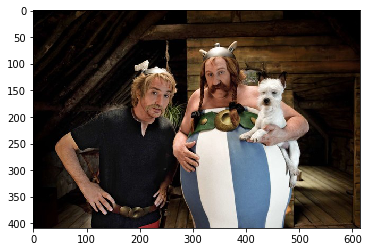

In [205]:
rgb_image = load_image('obelix.jpg')
plt.imshow(rgb_image)

In [206]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

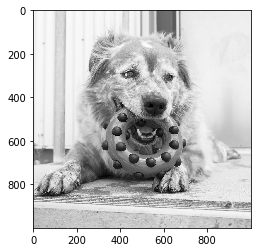

In [207]:
gray_image = rgb2gray(load_image('psiak.jpg'))
plt.imshow(gray_image, cmap='Greys_r')

In [208]:
edge = np.array([[-1.0, -1.0, -1.0], [-1.0, 8.0, -1.0], [-1.0, -1.0, -1.0]]).reshape(3, 3, 1)

sharpen = np.array([[0.0, -1.0, 0.0], [-1.0, 5.0, -1.0], [0.0, -1.0, 0.0]]).reshape(3, 3, 1)

kernels = [edge, sharpen]

## 1. Pierwsza metoda

In [209]:
def convolve_two_dimension_array(
    image: np.array, kernel: np.array, padding: int = 0, stride: int = 1
) -> np.array:
    """Basic moving kernel convolution

    Args:
        image (np.array): two dimension array of image we want to convolve
        kernel (np.array): two-dim array of filter (kernel) we want to apply
        padding (int, optional):  Number of pixels added to the photo from each side. Defaults to 0.
        stride (int, optional): Step size during kernel's movement. Defaults to 1.

    Returns:
        np.array: image after convolution
    """
    
    x_kernel_shape = kernel.shape[0]
    y_kernel_shape = kernel.shape[1]
    x_image_shape = image.shape[0]
    y_image_shape = image.shape[1]

    # Obliczamy wyjsciowe wymiary warstwy i inicjalizujemy ja zerami
    x_output = int(((x_image_shape - x_kernel_shape + 2 * padding) / stride) + 1)
    y_output = int(((y_image_shape - y_kernel_shape + 2 * padding) / stride) + 1)
    output = np.zeros((x_output, y_output))

    # Nakładamy padding rownomiernie z obu stron i wkladamy w srodek oryginalne zdjecie
    if padding != 0:
        padded_image = np.zeros(shape=(x_image_shape + padding * 2, y_image_shape + padding * 2))
        padded_image[padding:-padding, padding:-padding] = image
    else:
        padded_image = image

    # Przesuwamy sie w pionie o stride
    for y in range(0, y_image_shape, stride):
        # Jak skonczyly nam sie wiersze to wychodzimy z konwolucji
        if y > y_image_shape - y_kernel_shape:
            break
        for x in range(0, x_image_shape, stride):
            # Jak dojdziemy do konca wiersza, idziemy do nastepnego
            if x > x_image_shape - x_kernel_shape:
                break
            # Sumowanie po mnozeniu element-wise
            output[x, y] = np.sum(
                kernel * padded_image[x : x + x_kernel_shape, y : y + y_kernel_shape]
            )
    return output

In [210]:
def convolve_grayscale_image(
    image: np.array, kernel_list: list, padding: int = 0, stride: int = 1
) -> np.array:
    """Perform grayscale image convolution

    Args:
        image (np.array): image we want to convolve
        kernel_list (list): list of kernels
        padding (int, optional): Number of pixels added to the photo from each side. Defaults to 0.
        stride (int, optional): Step size during kernel's movement. Defaults to 1.

    Returns:
        np.array: convolved image
    """
    output = image
    for kernel in kernel_list:
        output = convolve_two_dimension_array(
            image=output, kernel=kernel, padding=padding, stride=stride
        )
        
    output[output < 0] = 0
    output[output > 255] = 255
    return output

In [211]:
def convolve_rgb_image(
    image: np.array, kernel_list: list, padding: int = 0, stride: int = 1
) -> np.array:
    """Perform rgb image convolution

        Args:
            image (np.array): image we want to convolve
            kernel_list (list): list of kernels
            padding (int, optional): Number of pixels added to the photo from each side. Defaults to 0.
            stride (int, optional): Step size during kernel's movement. Defaults to 1.

        Returns:
            np.array: convolved image
    """

    output_rgb_list = []

    for layer_number in range(image.shape[-1]):
        current_layer = image[:, :, layer_number]
        for kernel in kernel_list:
            current_layer = convolve_two_dimension_array(
                image=current_layer, kernel=kernel, padding=padding, stride=stride
            )
        output_rgb_list.append(current_layer)

    output = np.zeros(shape=(output_rgb_list[0].shape[0], output_rgb_list[0].shape[1], 3))
    output[:, :, 0] = output_rgb_list[0]
    output[:, :, 1] = output_rgb_list[1]
    output[:, :, 2] = output_rgb_list[2]
    
    output[output < 0] = 0
    output[output > 255] = 255
    return output

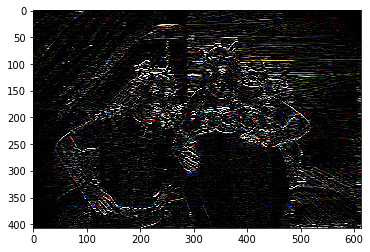

In [212]:
rgb_conv = convolve_rgb_image(image = rgb_image , kernel_list = [edge]).astype(np.uint8)
plt.imshow(rgb_conv)

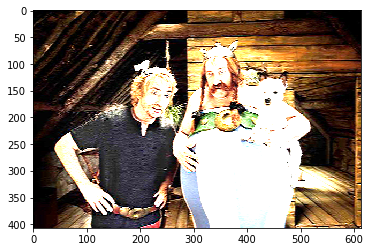

In [213]:
rgb_conv = convolve_rgb_image(image = rgb_image , kernel_list = [sharpen]).astype(np.uint8)
plt.imshow(rgb_conv)

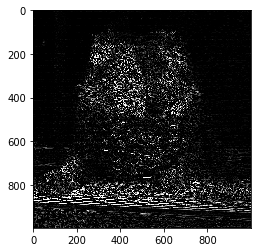

In [214]:
gray_conv = convolve_grayscale_image(image = gray_image, kernel_list = [edge]).astype(np.uint8)
plt.imshow(gray_conv, cmap='Greys_r')

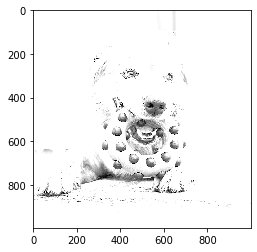

In [215]:
gray_conv = convolve_grayscale_image(image = gray_image, kernel_list = [sharpen]).astype(np.uint8)
plt.imshow(gray_conv, cmap='Greys_r')

## 2. Druga metoda

In [216]:
def im2col(image: np.array, kernel: np.array, stride: int = 1) -> np.array:
    """Basic im2col implementation, we assume padding = 0

    Args:
        image (np.array): two-dim array to perform im2col
        kernel (np.array): kernel which will be used on the image to reshape it properly
        stride (int, optional): Step size during kernel's movement. Defaults to 1.

    Returns:
        np.array: array after im2col operation
    """

    kernel_size = kernel.shape[0]
    m, n = image.shape
    s0, s1 = image.strides
    nrows = m - kernel_size + 1
    ncols = n - kernel_size + 1
    new_shape = kernel_size, kernel_size, nrows, ncols
    new_strides = s0, s1, s0, s1

    out_view = np.lib.stride_tricks.as_strided(image, shape=new_shape, strides=new_strides)
    return out_view.reshape(kernel_size * kernel_size, -1)[:, ::stride]

In [221]:
def convolve_grayscale_image_im2col(
    image: np.array, kernel_list: list, stride: int = 1
) -> np.array:
    """Perform im2col convolution on grayscale image

    Args:
        image (np.array): grayscale image
        kernel_list (list): list of kernels
        stride (int, optional): Step size during kernel's movement. Defaults to 1.

    Returns:
        np.array: convolved image
    """
    output = image
    for kernel in kernel_list:
        output_shape = (output.shape[0] - kernel.shape[0]) + 1
        im2col_matrix = im2col(output, kernel, stride)
        output = np.dot(kernel.flatten(), im2col_matrix)
        output = output.reshape(output_shape, output_shape)

    output[output < 0] = 0
    output[output > 255] = 255
    return output

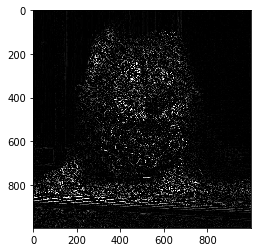

In [222]:
gray_conv = convolve_grayscale_image_im2col(image = gray_image, kernel_list = [edge]).astype(np.uint8)
plt.imshow(gray_conv, cmap='Greys_r')